### **EfficientNet-B0**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch [1/10], Train Loss: 0.8420, Top-1 Acc: 0.7190, Top-3 Acc: 0.9247
Epoch [1/10], Validation Loss: 0.8053, Top-1 Acc: 0.7380, Top-3 Acc: 0.9503
Epoch [2/10], Train Loss: 0.5297, Top-1 Acc: 0.8184, Top-3 Acc: 0.9668
Epoch [2/10], Validation Loss: 0.5454, Top-1 Acc: 0.8158, Top-3 Acc: 0.9640
Epoch [3/10], Train Loss: 0.4518, Top-1 Acc: 0.8439, Top-3 Acc: 0.9743
Epoch [3/10], Validation Loss: 0.4468, Top-1 Acc: 0.8498, Top-3 Acc: 0.9751
Epoch [4/10], Train Loss: 0.3957, Top-1 Acc: 0.8652, Top-3 Acc: 0.9788
Epoch [4/10], Validation Loss: 0.4044, Top-1 Acc: 0.8607, Top-3 Acc: 0.9779
Epoch [5/10], Train Loss: 0.3546, Top-1 Acc: 0.8790, Top-3 Acc: 0.9816
Epoch [5/10], Validation Loss: 0.5026, Top-1 Acc: 0.8408, Top-3 Acc: 0.9710
Epoch [6/10], Train Loss: 0.3260, Top-1 Acc: 0.8867, Top-3 Acc: 0.9845
Epoch [6/10], Validation Loss: 0.4408, Top-1 Acc: 0.8516, Top-3 Acc: 0.9764
Epoch [7/10], Train Loss: 0.3015, Top-1 Acc: 0.8956, Top-3 Acc: 0.9860
Epoch [7/10], Validation Loss: 0.4045, Top-1 Ac

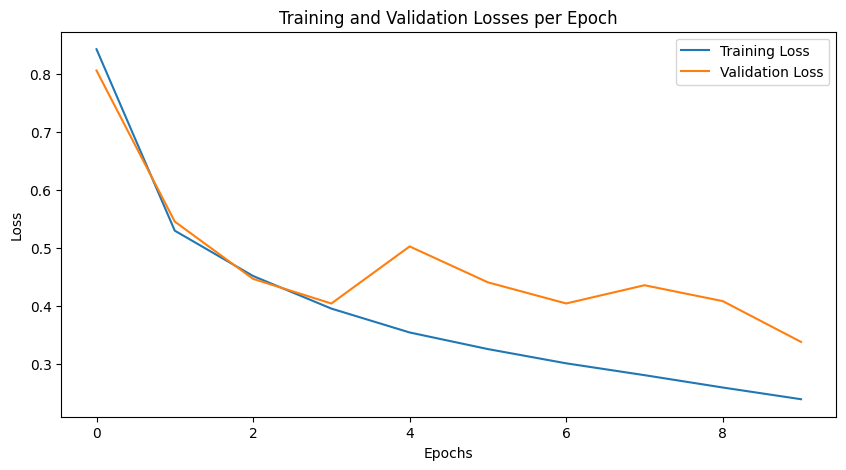

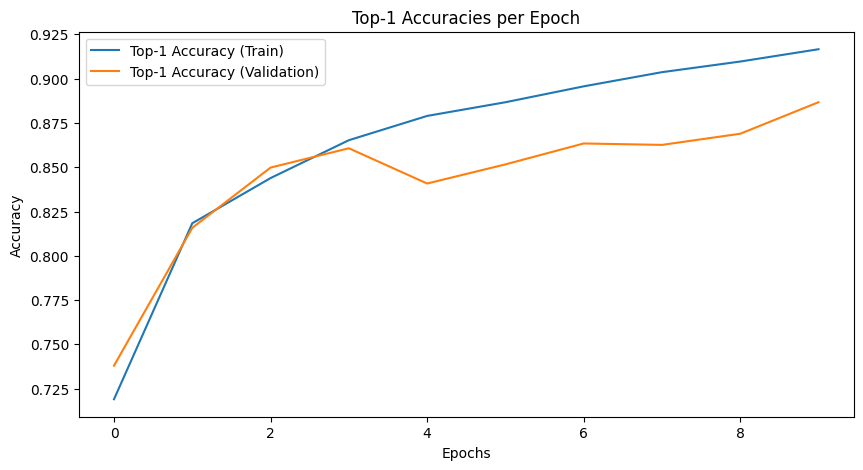

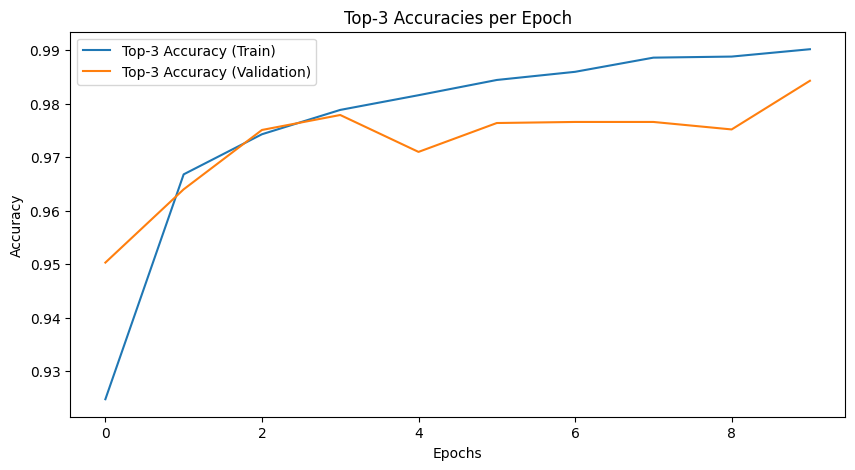

In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the EfficientNet-B0 model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    top1_accs = []
    top3_accs = []
    val_top1_accs = []
    val_top3_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_top1 = 0
        correct_top3 = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate top-1 accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct_top1 += (predicted == labels).sum().item()

            # Calculate top-3 accuracy
            _, predicted_top3 = torch.topk(outputs, 3, dim=1)
            correct_top3 += torch.sum(torch.eq(predicted_top3, labels.view(-1, 1)).any(dim=1)).item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        epoch_top1_acc = correct_top1 / total
        top1_accs.append(epoch_top1_acc)

        epoch_top3_acc = correct_top3 / total
        top3_accs.append(epoch_top3_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Top-1 Acc: {epoch_top1_acc:.4f}, Top-3 Acc: {epoch_top3_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_top1 = 0
        val_correct_top3 = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate top-1 accuracy
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct_top1 += (predicted == labels).sum().item()

                # Calculate top-3 accuracy
                _, predicted_top3 = torch.topk(outputs, 3, dim=1)
                val_correct_top3 += torch.sum(torch.eq(predicted_top3, labels.view(-1, 1)).any(dim=1)).item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        epoch_val_top1_acc = val_correct_top1 / val_total
        val_top1_accs.append(epoch_val_top1_acc)

        epoch_val_top3_acc = val_correct_top3 / val_total
        val_top3_accs.append(epoch_val_top3_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {epoch_val_loss:.4f}, Top-1 Acc: {epoch_val_top1_acc:.4f}, Top-3 Acc: {epoch_val_top3_acc:.4f}")

    return train_losses, val_losses, top1_accs, top3_accs, val_top1_accs, val_top3_accs

# Train the model
train_losses, val_losses, top1_accs, top3_accs, val_top1_accs, val_top3_accs = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses per Epoch')
plt.legend()
plt.show()

# Plot training and validation top-1 accuracies
plt.figure(figsize=(10, 5))
plt.plot(top1_accs, label='Top-1 Accuracy (Train)')
plt.plot(val_top1_accs, label='Top-1 Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Top-1 Accuracies per Epoch')
plt.legend()
plt.show()

# Plot training and validation top-3 accuracies
plt.figure(figsize=(10, 5))
plt.plot(top3_accs, label='Top-3 Accuracy (Train)')
plt.plot(val_top3_accs, label='Top-3 Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Top-3 Accuracies per Epoch')
plt.legend()
plt.show()